Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.8925000000000001
Final Accuracy: 0.915
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       183
         1.0       0.50      0.06      0.11        17

    accuracy                           0.92       200
   macro avg       0.71      0.53      0.53       200
weighted avg       0.88      0.92      0.88       200



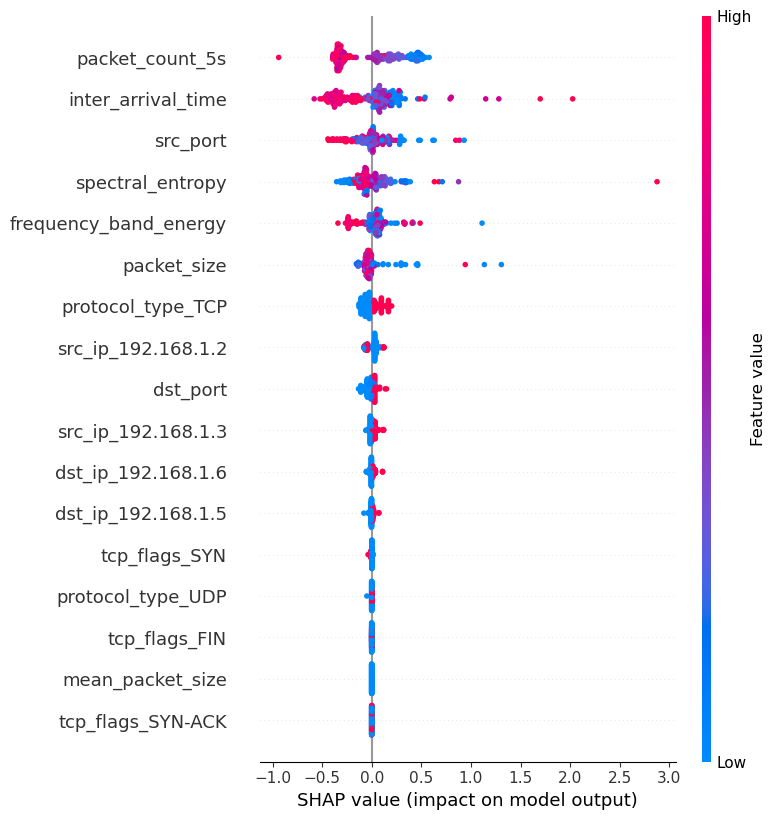

In [1]:
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("security.csv")
categorical_columns = ['protocol_type_TCP', 'protocol_type_UDP',
                       'tcp_flags_FIN', 'tcp_flags_SYN', 'tcp_flags_SYN-ACK']
df[categorical_columns] = df[categorical_columns].astype(int)
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbc = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [2]:
import joblib
joblib.dump(model, 'gradient_anomaly_model.pkl')



['gradient_anomaly_model.pkl']

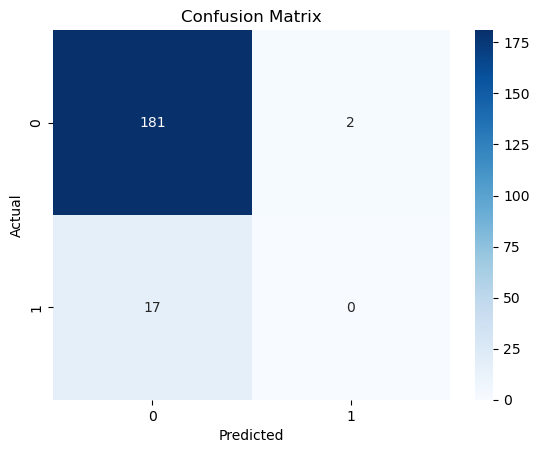

In [3]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

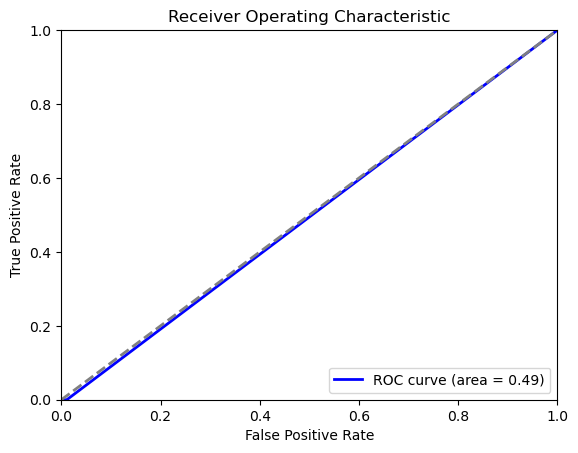

In [4]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

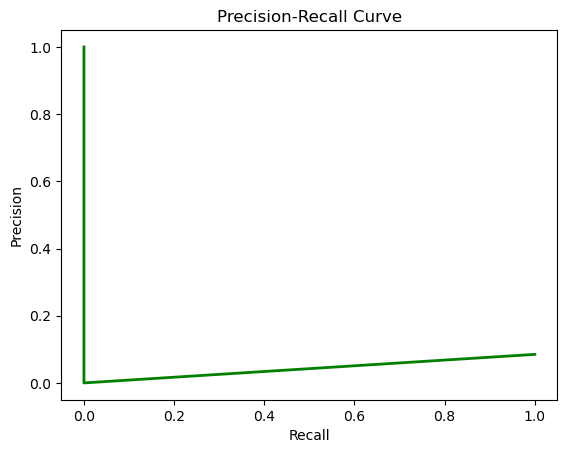

In [5]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

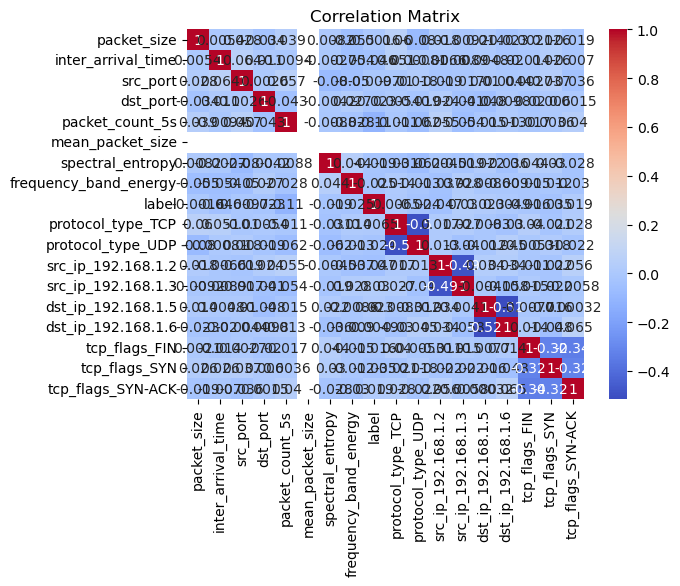

In [6]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
